# Capstone Project - The Battle of the Neighborhoods

#### IBM Data Science Professional Certificate



## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Exploratory Data Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion and Future Directions](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

* **Problem**: To reveal the competition intensity among Thai restuarants in Singapore by planning area.
* **Target Audience**: Business owners who are planning to open a Thai restuarant in Singapore. What's more, although it's for a Thai restuarant, it can be a reference for other restuarants too, given the similar logic and data applied.
* **Why would they care**: Starting a new F&B business is always not an easy job and knowing the competition intensity is important to formulate the strategy. There are many factors to take into consideration and some information can not be discovered by simply looking at the data. Using deep analytics techniques, data science is helpping more and more businesses with their daily problems and it's certain that when they encounter such a problem, they would like to see how data science reveals more insights and helps them make wiser decisions.

## Data <a name="data"></a>
When it comes to knowing the competition intensity among **Thai restaurants** in **Singapore**, we expect that at least the following three are considered:

* Details about existing Thai restaurants in different areas, such as number and locations; 
* Target customer of the opening restaurant. In this case, let's assume that it targets surrounding residents.
* The populaition of each planning area

In order to assess the above considerations, we need the following data:

* Geographical data including city map, division details of regions and panning areas , information of venus within assessed areas. These will be collected from statistical websites and geographical data provider such as Foursquare, using **Foursquare API** and **geocoders**. We will use **Folium** for plotting the map.
* Demographic data categorized by area. It is provided by **Singapore Department of Statistics**. We will use a ratio called "**Competitiveness Ratio**" to measure the competition intensity in each area. 

First of all, let's import the libraries and modeules required.

In [2]:
#Data analysis related
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe


#Data Visualization related
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

! pip install folium==0.5.0
import folium # plotting library

import matplotlib.pyplot as plt

print('Libraries and modules imported.')

     |████████████████████████████████| 79 kB 7.3 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=d4389418524016b26184d48f5fe282f2dabf19529c5985895b3899fbf4f6f94e
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Libraries and modules imported.


Then collect the population and planning area data from website. In order to make sense, we will use the population including all residents (citizens and non-citizens) but excluding citizens living abroad. As checked, the data is updated on 2020-06-30.

In [3]:
df=pd.read_html('https://www.citypopulation.de/en/singapore/admin/')
rawdata=df[0]
rawdata.head()

,Name,Status,PopulationCensus2000-06-30,PopulationCensus2010-06-30,PopulationEstimate2015-06-30,PopulationEstimate2020-06-30,Unnamed: 6
0,Ang Mo Kio,Planning Area,180112,179297,174770,162280,→
1,Ang Mo Kio Town Centre,Subzone,...,4982,5020,4810,→
2,Cheng San,Subzone,31911,30503,29770,28070,→
3,Chong Boon,Subzone,32859,29903,27900,26500,→
4,Kebun Bahru,Subzone,26765,25854,23910,22620,→


In [4]:
data=rawdata.iloc[:,[0,1,5]] #get columns we want
data=data.rename(columns={'Name':'Area','PopulationEstimate2020-06-30':'Population'})
data.drop([379],axis=0, inplace=True) #the last row is total for Singapore, drop it
data['Population']=(
    pd.to_numeric(data['Population'], errors='coerce').fillna(0)
)
data.astype({'Population':int})
data=data[data['Status']=='Planning Area']
data=data[['Area','Population']].reset_index(drop=True)
data.head(20)

,Area,Population
0,Ang Mo Kio,162280.0
1,Bedok,276990.0
2,Bishan,87320.0
3,Boon Lay,40.0
4,Bukit Batok,158030.0
5,Bukit Merah,151250.0
6,Bukit Panjang,138270.0
7,Bukit Timah,77860.0
8,Central Water Catchment,0.0
9,Changi,1850.0


Now we have the population data for every planning area in Singapore. Let's collect the corrdinates for each planning area and write them into the above dataframe we get.

In [14]:
coordinates=pd.DataFrame(np.nan, index=range(0,len(data)), columns=['Area','Latitude','Longitude','Population']) #create a new empty dataframe
coordinates['Area']=data['Area']
coordinates['Population']=data['Population']

for index in range(len(coordinates)):
    address = '{},Singapore'.format(coordinates.loc[index,'Area'])
    geolocator = Nominatim(user_agent="sg_explorer")
    location = geolocator.geocode(address)

    coordinates.loc[index,'Latitude']=location.latitude           
    coordinates.loc[index,'Longitude']=location.longitude

coordinates.head(20)

,Area,Latitude,Longitude,Population
0,Ang Mo Kio,1.370080,103.849523,162280.0
1,Bedok,1.323976,103.930216,276990.0
2,Bishan,1.350986,103.848255,87320.0
3,Boon Lay,1.338550,103.705812,40.0
4,Bukit Batok,1.349057,103.749591,158030.0
5,Bukit Merah,1.270439,103.828318,151250.0
6,Bukit Panjang,1.379149,103.761413,138270.0
7,Bukit Timah,1.354690,103.776372,77860.0
8,Central Water Catchment,1.375708,103.801743,0.0
9,Changi,1.351080,103.990064,1850.0


Next, let's get information about Thai restaurnts in each planning area using Foursquare API:

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    search_query = 'Thai'
    
    venues_list=[]
   
    for index in range(0,len(coordinates)):    
    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, latitudes[index], longitudes[index], ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']
    
        for v in results['venues']:
                tmp=[]
                tmp.append(coordinates.loc[index,'Area'])
                tmp.append(coordinates.loc[index,'Latitude'])
                tmp.append(coordinates.loc[index,'Longitude'])
                tmp.append(v['name'])
                tmp.append(v['location']['lat'])
                tmp.append(v['location']['lng'])
                if len(v['categories'])>0:
                    tmp.append(v['categories'][0]['name'])
                else:
                    tmp.append('Not specified')
                venues_list.append(tmp)


    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Area','Area Latitude','Area Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    
    return(nearby_venues)


thai_restaurants = getNearbyVenues(names=coordinates['Area'],
                                   latitudes=coordinates['Latitude'],
                                   longitudes=coordinates['Longitude'])
thai_restaurants=thai_restaurants[thai_restaurants['Venue Category']=='Thai Restaurant']
thai_restaurants=thai_restaurants.reset_index(drop=True)
thai_restaurants.head(21)

,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.370080,103.849523,Ruan Thai,1.365686,103.848842,Thai Restaurant
1,Ang Mo Kio,1.370080,103.849523,Thai Express,1.369061,103.847810,Thai Restaurant
2,Ang Mo Kio,1.370080,103.849523,Thonglor Thai Restaurant,1.373030,103.847660,Thai Restaurant
3,Ang Mo Kio,1.370080,103.849523,Nagara Thai,1.372538,103.855652,Thai Restaurant
4,Ang Mo Kio,1.370080,103.849523,Na Na Original Thai Food,1.365087,103.848990,Thai Restaurant
5,Ang Mo Kio,1.370080,103.849523,Lotus Thai Restaurant,1.372459,103.848021,Thai Restaurant
6,Ang Mo Kio,1.370080,103.849523,Pok Pok Thai Kitchen,1.366854,103.851089,Thai Restaurant
7,Ang Mo Kio,1.370080,103.849523,Thai Fusion Wanton Mee,1.364278,103.849747,Thai Restaurant
8,Ang Mo Kio,1.370080,103.849523,Thai Ying Luck,1.372132,103.855695,Thai Restaurant
9,Ang Mo Kio,1.370080,103.849523,天天来 Authentic Thai Cuisine,1.365465,103.848442,Thai Restaurant


In order to visualize the above dataframe, let's create a map to mark all the Thai restaurants:

In [8]:
address = 'Singapore'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Thai restaurant using latitude and longitude values
map_thai_restr = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(thai_restaurants['Venue Latitude'], thai_restaurants['Venue Longitude'], thai_restaurants['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_thai_restr)  
    
map_thai_restr

Let's get the number of Thai restaurant in each planning area:

In [9]:
thai_restr_count=thai_restaurants.groupby('Area').count()
thai_restr_count=thai_restr_count['Venue'].to_frame()
thai_restr_count.head()

,Venue
Area,
Ang Mo Kio,15
Bedok,15
Bishan,10
Boon Lay,5
Bukit Batok,5


Until now, we get **the latitude and logitude** of each planning area, **population figures** by planning area and **number of Thai restaurant** in each area. This concludes our data gathering and wraggling sections. 

## Methodology <a name="methodology"></a>

In this case, we assume that the Thai restaurant to be opened targets its surrounding residents.Therefore, we have to compare relative density of Thai restaurant in each area. One area can has low Thai restaurant density with a number of Thai restaurants if its population is also large. To calculate this relativity, we use a ratio calculated by dividing the population by the number of Thai restaurant in the area and name it as 'Competitiveness Ratio'. As the original ratio is big due to the large population figures, we adjust it by dividing it by 1000. **The bigger the 'Competitiveness Ratio', the lower the competition in the area.** When the 'Competitiveness Ratio' is zero, it means it's not recommanded to open the restraurant in that area as the area has no resident.

## Exploratory Data Analysis <a name="analysis"></a>

In the last section, we get the latitude and logitude of each planning area, population figures by planning area and number of Thai restaurant in each area. Before starting the analysis, let's put all these data into one dataframe:

In [10]:
#merge two dataframes
coord=coordinates.set_index('Area')
competition = pd.concat([coord, thai_restr_count], axis=1).replace(np.nan, 0)
competition.index.name='Area'

#change data types for calculation
competition['Population']=competition['Population'].astype('int64')
competition['Venue']=competition['Venue'].astype('int64')
competition.rename(columns={'Venue':'Thai Restaurant'},inplace=True)
competition

,Latitude,Longitude,Population,Thai Restaurant
Area,,,,
Ang Mo Kio,1.370080,103.849523,162280,15
Bedok,1.323976,103.930216,276990,15
Bishan,1.350986,103.848255,87320,10
Boon Lay,1.338550,103.705812,40,5
Bukit Batok,1.349057,103.749591,158030,5
Bukit Merah,1.270439,103.828318,151250,12
Bukit Panjang,1.379149,103.761413,138270,2
Bukit Timah,1.354690,103.776372,77860,0
Central Water Catchment,1.375708,103.801743,0,0


Now we can calculate the ratio in a new column and rearrange the data frame with descending values based on the 'Competitiveness Ratio': 

In [13]:
competition['Competitiveness Ratio']=competition['Population']*0.001/(competition['Thai Restaurant']+1)
competition.sort_values(by=['Competitiveness Ratio'],ascending=False,inplace=True)
competition.head(30)

,Latitude,Longitude,Population,Thai Restaurant,Competitiveness Ratio
Area,,,,,
Choa Chu Kang,1.384749,103.744534,192070,0,192.070000
Bukit Timah,1.354690,103.776372,77860,0,77.860000
Punggol,1.405197,103.902350,174450,2,58.150000
Jurong West,1.339636,103.707339,262730,4,52.546000
Bukit Panjang,1.379149,103.761413,138270,2,46.090000
Sengkang,1.391924,103.895491,249370,5,41.561667
Tampines,1.354653,103.943571,259900,6,37.128571
Woodlands,1.436897,103.786216,255130,7,31.891250
Hougang,1.370801,103.892544,227560,7,28.445000


Let's visualize the top 30 areas by generating a bar chart with horizontal bars.

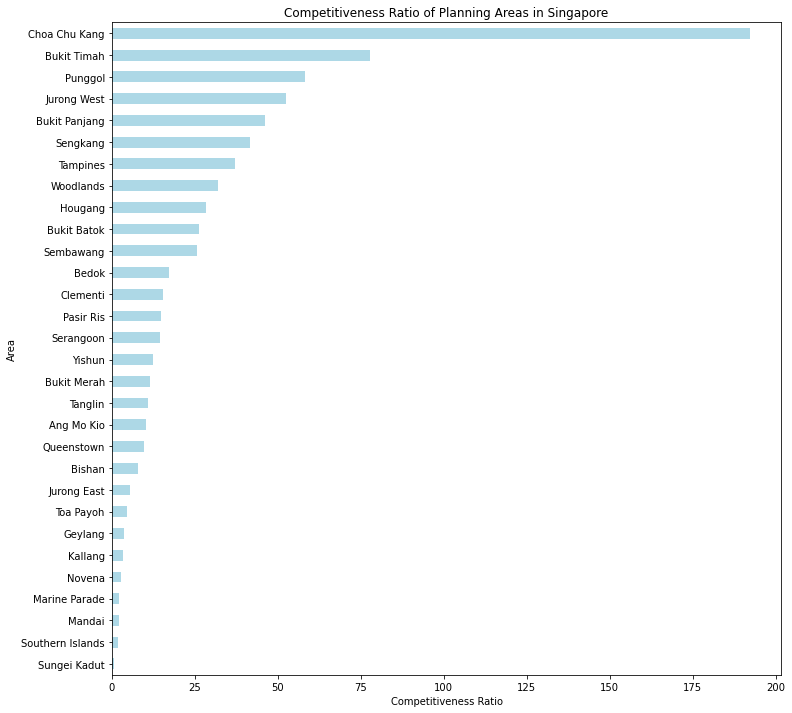

In [12]:
ratio=competition['Competitiveness Ratio'].head(30)
ratio.sort_values(ascending=True,inplace=True)

ratio.plot(kind='barh', figsize=(12, 12),color='lightblue',edgecolor = "none", linewidth=0)

plt.xlabel('Competitiveness Ratio')
plt.title('Competitiveness Ratio of Planning Areas in Singapore') 

plt.show()

## Results and Discussion <a name="results"></a>

Based on the result above, the area 'Choa Chu Kang' and 'Bukit Timah' have higher Competitiveness Ratio than the rest because although they have large population, but there is no proper Thai restraurant in these two areas. It means these two area can be top choices to start a Thai restraurant business.

## Conclusion and Future Directions <a name="conclusion"></a>

In this project, leveraging geographical data, we explored the details of Thai resturants in each planning area in Singapore and we mapped the distribution of them. By counting the number of Thai restaurant in each area, we are provided an idea about the density of Thai restaurants. Furthermore, with demographic data, we calculate a ratio named 'Competitiveness Ratio' in order to compare the relative number of local residents accessable around the future restraurant in different areas. 

In this project, we assume the future Thai restaurant targets its surrounding residents. If it wants to target population outside the area it lies, we may consider daily movement of population among different areas, which can give restraurants in central areas more benefits.\
On the other hand, when choosing location for a business, rent for retail space is also an important consideration and we can take this into account in the future analytics.